In [1]:
import vmas

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import pandas as pd

import imageio

from IPython import display

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

print(f"Using device: {device}")

num_epochs = 1024  # Total number of training epochs, i.e. number of steps
max_steps = 256  # Episode steps before reset
num_vmas_envs = 1  # Number of vectorized environments to simulate at once

Using device: cpu


In [3]:
navigation_args = {
    "scenario" : "navigation",
    "n_agents": 2,
    "shared_rew": False,
}

flocking_args = {
    "scenario" : "flocking",
    "n_agents": 2,
}

sampling_args = {
    "scenario" : "sampling",
    "n_agents": 2,
    "shared_rew": False,
}

# Choose the scenario
args = navigation_args
#args = sampling_args

env = vmas.make_env(
    num_envs=num_vmas_envs,
    continuous_actions=False, # Use discrete actions
    max_steps=max_steps,
    device=device,
    dict_spaces=True, # Use a dictionary for the observation and action spaces, instead of a tuple

    # Scenario custom args
    **args
)

print("Action spaces:", env.action_space)
print("Observation spaces:", env.observation_space)

# Get list of agents
agent_names = [agent.name for agent in env.agents]

# Get the name of the first agent
first_agent = agent_names[0]

# Obtain the size of the action space
action_size = env.action_space[first_agent].n

# Obtain the size of the observation space
observation_size = env.observation_space[first_agent].shape[0]

print("Action size:", action_size)
print("Observation size:", observation_size)
print("Environments size:", num_vmas_envs)

Action spaces: Dict('agent_0': Discrete(9), 'agent_1': Discrete(9))
Observation spaces: Dict('agent_0': Box(-inf, inf, (18,), float32), 'agent_1': Box(-inf, inf, (18,), float32))
Action size: 9
Observation size: 18
Environments size: 1


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, observation_size, action_size, lr=1e-4, hidden_layers=[128]):
        """
        Initialize the actor-critic network.

        Args:
            observation_size (int): Size of the observation space.
            action_size (int): Size of the action space.
            lr (float, optional): Learning rate. Defaults to 1e-4.
            hidden_layers (list, optional): List of hidden layer sizes. Defaults to [128].
        """
        super(ActorCritic, self).__init__()

        # The actor and critic share part of the network
        layers = [nn.Linear(observation_size, hidden_layers[0]), nn.ReLU()]
        for hidden_size in hidden_layers[1:]:
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.shared = nn.Sequential(*layers)

        # Actor head, returns a probability distribution over actions
        self.actor = nn.Linear(hidden_layers[-1], action_size)

        # Critic head, returns a value estimate for a given state
        self.critic = nn.Linear(hidden_layers[-1], 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):
        """
        Runs the Neural Network forward pass.

        Args:
            state (torch.Tensor): The current state of the environment.

        Returns:
            policy (torch.Tensor): The policy distribution over actions.
            value (torch.Tensor): The value estimate for the given state.
        """
        x = self.shared(state)

        # Apply softmax to get the policy
        policy = torch.softmax(self.actor(x), dim=-1)
        value = self.critic(x)

        return policy, value

class ICM(nn.Module):
    def __init__(self, observation_size, action_size, lr=1e-4,  hidden_size=128):
        super(ICM, self).__init__()
        # Inverse Model: Predict action from state and next state
        self.inverse_model = nn.Sequential(
            nn.Linear(2 * observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
        # Forward Model: Predict next state from state and action
        self.forward_model = nn.Sequential(
            nn.Linear(observation_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, observation_size)
        )

        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, state, next_state, action):
        # Predict action (inverse)
        inverse_input = torch.cat([state, next_state], dim=1)
        predicted_action = self.inverse_model(inverse_input)

        # Predict next state (forward)
        forward_input = torch.cat([state, action], dim=1)
        predicted_next_state = self.forward_model(forward_input)

        return predicted_action, predicted_next_state
    
class EMANormalizer:
    def __init__(self, alpha=0.99, epsilon=1e-8):
        """
        Exponential Moving Average Normalizer, used for normalizing rewards while giving more weights to recent rewards.`
        """
        self.mean = 0.0
        self.var = 0.0
        self.alpha = alpha
        self.epsilon = epsilon

    def update(self, reward):
        delta = reward - self.mean
        self.mean += self.alpha * delta
        self.var += self.alpha * (delta**2 - self.var)

    def normalize(self, reward):
        std = (self.var)**0.5 + self.epsilon
        return (reward - self.mean) / std

In [ ]:
class PPO:
    def __init__(self, env, observation_size, action_size, num_epochs=1024):
        """
        Initialize the PPO agent.

        Args:
            env (gym.Env): The environment to interact with.
            observation_size (int): Size of the observation space.
            action_size (int): Size of the action space.
            num_epochs (int, optional): Number of training epochs. Defaults to 1024.
        """
        self.env = env
        self.observation_size = observation_size
        self.action_size = action_size
        self.num_agents = len(self.env.agents)

        self.training_epochs = num_epochs

        # Reward Normalization Functions
        self.extrinsic_rn = EMANormalizer()
        self.intrinsic_rn = EMANormalizer()

        # Early stopping hyperparameters
        self.init_patience = 8 # Number of epochs to wait before early stopping
        self.patience = self.init_patience
        self.min_steps = 64 # Minimum number of epochs before early stopping

        # Entropy-Based Exploration Hyperparameters
        self.entropy_coeff = 0.02
        self.min_entropy_coeff = 0.01
        self.entropy_decay = 0.999

        # PPO Hyperparameters
        self.gamma = 0.99 # Discount factor
        self.lmbda = 0.8 # Lambda for GAE
        self.clip_epsilon = 0.2 # Clipping epsilon
        self.ppo_iters = 4 # Number of PPO iterations

        # Learning rates
        policy_lr = 1e-3
        icm_lr = 1e-3

        # Initialize the shared model
        layers = [32]
        self.shared_model = ActorCritic(observation_size, action_size, lr=policy_lr, hidden_layers=layers).to(device)

        # Initialize the curiosity model
        #self.icm = ICM(observation_size, action_size, lr=icm_lr, hidden_size=128).to(device)
        self.intrinsic_reward_weight = 1.0
        self.extrinsic_reward_weight = 1.0
        self.min_intrinsic_reward = 0.1
        self.decay_factor = 0.999

    def collect_rollout(self, env):
        """
        Runs the environment by a number of steps and returns the collected rollouts

        Args:
            env (gym.Env): The environment to interact with.

        Returns:
            rollouts (dict): A dictionary containing the collected rollouts for each agent.
            steps (int): The number of steps taken in the environment for this episode.
            rewards (dict): A dictionary containing the total rewards for each agent.
        """
        rollouts = {agent.name: [] for agent in env.agents}
        list_rewards = []

        steps = 0

        obs = env.reset()
        dones = [False]

        # Keep going until done
        while True:
            steps += 1
            actions = {}

            # Get the action of each agent
            for agent in env.agents:
                policy, _ = self.shared_model(obs[agent.name])

                # Obtain the action from the policy
                action = torch.multinomial(policy, num_samples=1)
                actions[agent.name] = action

            next_obs, rewards, dones, _ = env.step(actions)

            for agent in env.agents:
                # Convert action to tensor with one-hot encoding
                #action_tensor = nn.functional.one_hot(actions[agent.name], num_classes=self.action_size).float().squeeze(1).to(device)
                # Compute the intrinsic reward
                #_, predicted_next_state = self.icm(obs[agent.name], next_obs[agent.name], action_tensor)
                #intrinsic_reward = self.icm.mse_loss(predicted_next_state, next_obs[agent.name])

                extrinsic_reward = rewards[agent.name]

                # Update the reward normalizers
                self.extrinsic_rn.update(extrinsic_reward)
                #self.intrinsic_rn.update(intrinsic_reward)

                # Normalize both rewards
                extrinsic_reward = self.extrinsic_rn.normalize(extrinsic_reward)
                #intrinsic_reward = self.intrinsic_rn.normalize(intrinsic_reward)

                # Combine the intrinsic and extrinsic rewards using the hyperparameters
                #comb_rew = extrinsic_reward * self.extrinsic_reward_weight + intrinsic_reward * self.intrinsic_reward_weight
                comb_rew = extrinsic_reward

                list_rewards.append(extrinsic_reward)

                # Store the rollouts
                rollouts[agent.name].append((obs[agent.name], actions[agent.name], comb_rew.item(), next_obs[agent.name], dones))

            obs = next_obs
            if any(dones):
                break

        avg_reward = sum(list_rewards) / len(list_rewards)

        return rollouts, steps, avg_reward.item()
    
    def train_icm(self, rollouts):
        """
        Trains the curiosity model using the rollouts previously collected

        Args:
            rollouts (dict): A dictionary containing the collected rollouts for each agent.
        """
        for agent in rollouts.keys():
            # Obtain the rollouts of each individual agent
            agent_rollouts = rollouts[agent]
            obs, actions, _, next_obs, _ = zip(*agent_rollouts)

            # Convert to tensors
            obs = torch.stack(obs).squeeze(1)
            next_obs = torch.stack(next_obs).squeeze(1)
            
            actions = nn.functional.one_hot(torch.tensor(actions), num_classes=self.action_size).float().squeeze(1).to(device)

            # Train the curiosity model
            predicted_actions, predicted_next_state = self.icm(obs, next_obs, actions)

            # Inverse loss
            inverse_loss = nn.CrossEntropyLoss()(predicted_actions, actions)

            # Forward loss
            forward_loss = self.icm.mse_loss(predicted_next_state, next_obs)

            # Total loss
            loss = inverse_loss + forward_loss * 0.2

            # Backpropagate
            self.icm.optimizer.zero_grad()
            loss.backward()
            self.icm.optimizer.step()

    def get_advantages(self, rollouts):
        """
        Computes the advantages for each agent using Generalized Advantage Estimation from the rollouts previously collected

        Args:
            rollouts (dict): A dictionary containing the collected rollouts for each agent.

        Returns:
            advantages (dict): A dictionary containing the advantages for each agent.
        """
        advantages = {agent: [] for agent in rollouts.keys()}
        for agent in rollouts.keys():
            # Obtain the rollouts of each individual agent
            agent_rollouts = rollouts[agent]
            obs, _, rewards, next_obs, dones = zip(*agent_rollouts)

            # Convert tuples of tensors to tensors
            obs = torch.stack(obs)
            next_obs = torch.stack(next_obs)
            rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
            dones = torch.tensor(dones, dtype=torch.float32, device=device)

            # Get the values from the critic
            _, values = self.shared_model(obs)
            _, next_values = self.shared_model(next_obs)

            # Remove extra dimensions
            values = values.squeeze()
            next_values = next_values.squeeze()

            # Compute the advantages
            returns = []
            advantage = 0.0
            for reward, value, next_value, done in zip(reversed(rewards), reversed(values), reversed(next_values), reversed(dones)):
                # Generalized Advantage Estimation
                td_error = reward + (1 - done) * self.gamma * next_value - value
                advantage = td_error + self.gamma * self.lmbda * advantage
                returns.insert(0, advantage + value)  # GAE + baseline

            advantages[agent] = torch.tensor(returns, dtype=torch.float32, device=device)

        return advantages

    def ppo_update(self, rollouts, advantages):
        """
        Updates the policy using Proximal Policy Optimization from the rollouts previously collected

        Args:
            rollouts (dict): A dictionary containing the collected rollouts for each agent.
            advantages (dict): A dictionary containing the advantages for each agent.

        Returns:
            policy_loss (float): The loss of the policy.
        """
        all_obs, all_adv, all_actions = [], [], []

        # Collect all observations, actions and returns of the different agents into a single tensor
        for agent in rollouts.keys():
            obs, act, _, _, _ = zip(*rollouts[agent])
            all_obs.extend(obs)
            all_adv.extend(advantages[agent])
            all_actions.extend(act)

        # Stack into a single tensor
        obs = torch.stack(all_obs)
        act = torch.stack(all_actions)
        adv = torch.stack(all_adv)

        # Train the ICM module
        #self.train_icm(rollouts)

        policy, _ = self.shared_model(obs)

        # Get the shape of the policy and the actions to be compatible
        policy = policy.squeeze(1)
        act = act.squeeze(1)

        old_policy_probs = policy.detach().gather(1, act)

        for _ in range(self.ppo_iters):
            policy, values = self.shared_model(obs)

            policy = policy.squeeze(1)
            # Compute action probabilities
            policy_probs = policy.gather(1, act)

            # Compute the ratio of probabilities
            ratios = (policy_probs / old_policy_probs).squeeze()
            clip = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon)

            # Compute returns, advantages minus baseline
            returns = adv - values.squeeze().detach()

            # Policy loss
            policy_loss = -torch.min(ratios * returns, clip * returns).mean()

            # Value loss
            value_loss = nn.MSELoss()(values.squeeze(), adv)

            # Entropy loss
            entropy_loss = -(policy * torch.log(policy + 1e-8)).sum(dim=-1).mean()

            # Total loss
            loss = policy_loss + 0.5 * value_loss - self.entropy_coeff * entropy_loss

            # Backward pass
            self.shared_model.optimizer.zero_grad()
            loss.backward()

            # Clip gradients
            #torch.nn.utils.clip_grad_norm_(self.shared_model.parameters(), max_norm=1.0)

            self.shared_model.optimizer.step()           

        return policy_loss.item()

    def train(self):
        """
        Trains the agents using Proximal Policy Optimization
        """
        def update_plot(fig, ax1, ax2, df, hdisplay):
            # Update the plot title
            fig.suptitle(f'{args["scenario"]}: Episode {df["episode"].iloc[-1]}')

            ax1.clear()
            ax2.clear()
            ax3.clear()

            ax1.plot(df['episode'], df['steps'], label='Steps')
            ax1.plot(df['episode'], df['mean_steps'], label='Mean Steps')
            ax1.set_title('Steps per Episode:')
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Steps')
            ax1.legend()

            ax2.plot(df['episode'], df['loss'], label='Loss')
            ax2.plot(df['episode'], df['mean_loss'], label='Mean Loss')
            ax2.set_title('Loss per Episode')
            ax2.set_xlabel('Episode')
            ax2.set_ylabel('Loss')
            ax2.legend()

            ax3.plot(df['episode'], df['reward'], label='Reward')
            ax3.plot(df['episode'], df['mean_reward'], label='Mean Reward')
            ax3.set_title('Reward per Episode')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Reward')
            ax3.legend()

            fig.canvas.draw()

            hdisplay.update(fig)

        """ Training Logging """
        df = pd.DataFrame(columns=['episode', 'steps', 'mean_steps', 'loss', 'mean_loss', 'reward', 'mean_reward'])
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        hdisplay = display.display("Starting training", display_id=True)

        best = float('inf')

        for episode in range(self.training_epochs):
            """ PPO Rollout and Update """
            rollouts, steps, reward = self.collect_rollout(self.env)
            advantages = self.get_advantages(rollouts)
            policy_loss = self.ppo_update(rollouts, advantages)

            """ Hyperparameters Update """
            # Update the entropy coefficient, to make the policy less explorative as it improves
            self.entropy_coeff = max(self.entropy_coeff * self.entropy_decay, self.min_entropy_coeff)
            # Update the instrinsic reward scale, to make the extrinsic reward more important over time
            self.intrinsic_reward_weight = max(self.intrinsic_reward_weight * self.decay_factor, self.min_intrinsic_reward)

            """ Logging """
            # Calculate the mean of the last min_steps
            mean_steps = df['steps'].iloc[-self.min_steps:].mean()
            mean_loss = df['loss'].iloc[-self.min_steps:].mean()
            mean_reward = df['reward'].iloc[-self.min_steps:].mean()

            df.loc[episode] = [episode, steps, mean_steps, policy_loss, mean_loss, reward, mean_reward]
            update_plot(fig, ax1, ax2, df, hdisplay)

            """ Early Stopping
            # Reset patience as the model is improving
            if episode >= self.min_steps:
                if df['mean_steps'].iloc[-1] <= best:
                    self.patience = self.max_patience
                    best = df['mean_steps'].iloc[-1]
                else:
                    self.patience -= 1
                    if self.patience == 0:
                        break
            """

    def test(self):
        """
        Tests the trained agents using the environment and renders the environment
        """
        while True:
            obs = self.env.reset()
            dones = [False]
            while not dones[0]:
                actions = {}
                # Get the action of each agent
                for agent in env.agents:
                    policy, _ = self.shared_model(obs[agent.name])

                    # Obtain the action from the policy
                    action = torch.multinomial(policy, num_samples=1)
                    actions[agent.name] = action
                
                obs, _, dones, _ = self.env.step(actions)

                self.env.render(mode="human")
    
    def create_gif(self, path, num_simulations=1):
        """
        Creates a gif of the environment
        """
        frames = []

        for _ in range(num_simulations):
            obs = self.env.reset()
            dones = [False]
            while not dones[0]:
                frame = self.env.render(mode="rgb_array")
                frames.append(frame)

                actions = {}
                # Get the action of each agent
                for agent in env.agents:
                    policy, _ = self.shared_model(obs[agent.name])

                    # Obtain the action from the policy
                    action = torch.multinomial(policy, num_samples=1)
                    actions[agent.name] = action
                
                obs, _, dones, _ = self.env.step(actions)

        imageio.mimsave(path, frames, 'GIF', fps=30)

    def save(self):
        torch.save(self.shared_model.state_dict(), f"models/{args['scenario']}_policy.pth")
        #torch.save(self.icm.state_dict(), f"models/{args['scenario']}_icm.pth")

    def load(self):
        self.shared_model.load_state_dict(torch.load(f"models/{args['scenario']}_policy.pth"))
        #self.icm.load_state_dict(torch.load(f"models/{args['scenario']}_icm.pth"))

    def play(self):
        """
        Runs the interactive environment
        """
        vmas.render_interactively(args.scenario, display_info=False)

ppo = PPO(env, observation_size, action_size)

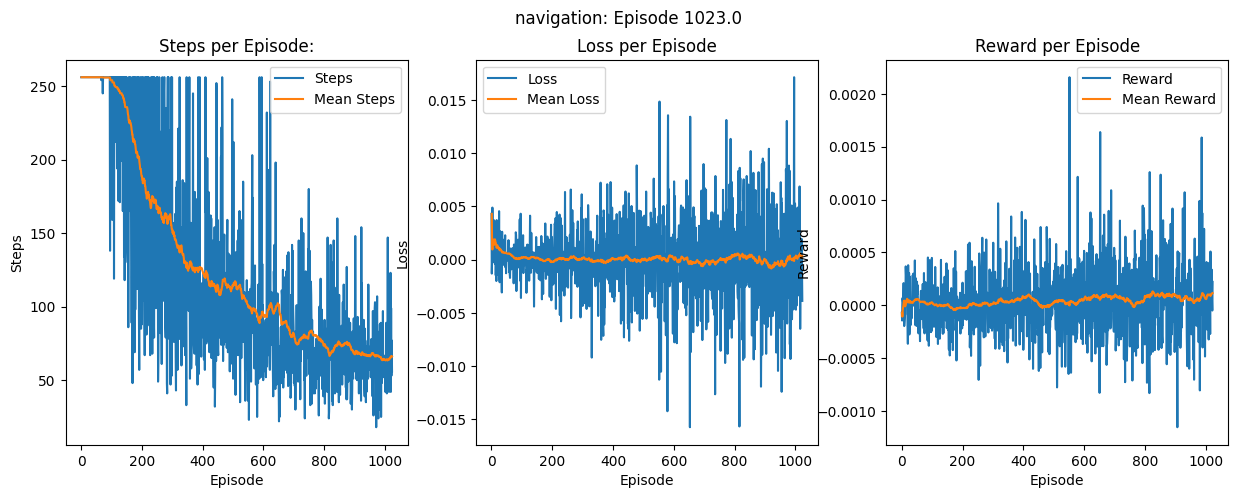

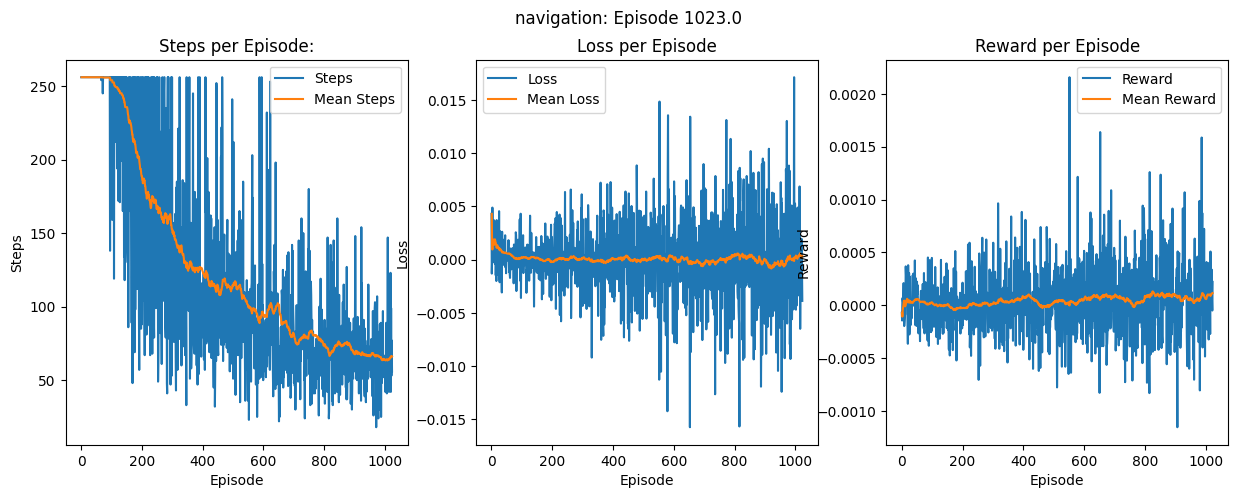

In [6]:
# Train the model
ppo.train()

In [7]:
# Test the trained model
ppo.test()

ArgumentError: argument 2: TypeError: wrong type

In [8]:
# Save the models
ppo.save()

In [ ]:
# Load the model
ppo.load()

In [ ]:
# Create a gif of the environment
ppo.create_gif(f"{args['scenario']}.gif", num_simulations=2)

In [ ]:
!pip install torch torchvision torchaudio
!pip install vmas
!pip install vmas[all]
!pip install matplotlib
!pip install pandas
!pip install imageio